In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numpy.random import *
from scipy import special
%matplotlib inline

In [2]:
nSamples = 10000

a = 1.0
sig = 1.4
q = 10

gauss = lambda((x,mu,sig)): 1.0/np.sqrt(2*np.pi*sig**2)*np.exp(-(x-mu)**2/(2.0*sig**2))
lapl = lambda((x,a)): a*np.exp(-a*x)*(x>=0)
PMcomb = lambda((x,a,sig)): a*np.exp(-a*x+ a**2*sig**2/2.0)*special.erfc(a*sig/np.sqrt(2)-x/(np.sqrt(2)*sig))/2.0

HQ = np.linspace(5,5,100)

mMin = 0
mMax = 20
M = np.linspace(mMin,mMax,nSamples)

def monteCarlo(m, hq, q, sig, a):
    PMQ = gauss((m,q,sig))
    PMHQ = gauss((m,hq,sig))
    PM = PMcomb((m,a,sig)) # exact distrib
    PHQ = lapl((hq,a))
    
    INTEGRAND = PMQ*PMHQ/PM*PHQ/nSamples*(mMax-mMin)
    
    PHQQ = INTEGRAND.sum()
    
    return PHQQ, PHQ, PMQ, PMHQ, PM

def monteCarloB(m, hq, q, sig, a):
    PMQ = gauss((m,q,sig))
    PMHQ = gauss((m,hq,sig))
    PM = lapl((m,a)) # laplace approx
    PHQ = lapl((hq,a))
    
    INTEGRAND = PMQ*PMHQ/PM*PHQ
    
    PHQQ = INTEGRAND.sum()
    
    return PHQQ, PHQ, PMQ, PMHQ, PM

nEch = 10000   
res = np.zeros(nEch)
PHQ = np.zeros((nEch))
PMHQ = np.zeros((nSamples,nEch))
resB = np.zeros(nEch)
PHQB = np.zeros((nEch))
PMHQB = np.zeros((nSamples,nEch))

i = 0
HQ = np.linspace(mMin,mMax,nEch)
for hq in HQ:
    res[i], PHQ[i], PMQ, PMHQ[:,i], PM = monteCarlo(M,hq,q,sig,a)    
    resB[i], PHQB[i], PMQB, PMHQB[:,i], PMB = monteCarloB(M,hq,q,sig,a)    
    i+=1

resB = resB/resB.sum()*nSamples/mMax
meanPMQB = np.sum(M*PMQB)*mMax/nSamples
meanResB = np.sum(M*resB)*mMax/nSamples

meanPMQ = np.sum(M*PMQ)*mMax/nSamples
meanRes = np.sum(M*res)*mMax/nSamples


In [3]:
print 'Likelihood mean: %.4f, Posterior mean: %.4f'%(meanPMQ,meanRes)
print 'Theoretical mean difference: %.4f, Numerical mean difference: %.4f'%(a*sig**2,np.abs(meanPMQ-meanRes))
print ' '
print 'Likelihood std: %.4f, Posterior std: %.4f'%(np.sqrt(np.sum((M-meanPMQ)**2*PMQ)*mMax/nSamples),\
                    np.sqrt(np.sum((M-meanRes)**2*res)*mMax/nSamples))
print 'Theoretical std ratio: %.4f, Numerical std ratio: %.4f'%(np.sqrt(2),\
                    np.sqrt(np.sum((M-meanRes)**2*res)*mMax/nSamples)/sig)

Likelihood mean: 9.9990, Posterior mean: 8.0385
Theoretical mean difference: 1.9600, Numerical mean difference: 1.9605
 
Likelihood std: 1.3999, Posterior std: 1.9794
Theoretical std ratio: 1.4142, Numerical std ratio: 1.4138


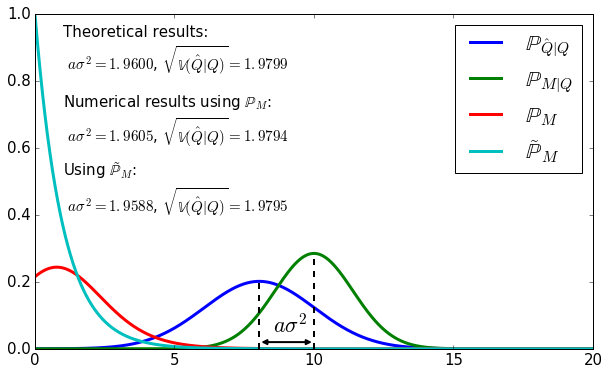

In [4]:
fig1, axes1 = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))

axes1.plot(HQ,res, lw=3, label=r'$\mathbb{P}_{\hat Q|Q}$')
axes1.plot(HQ,PMQ, lw=3, label=r'$\mathbb{P}_{M|Q}$')
axes1.plot(HQ,PM, lw=3, label=r'$\mathbb{P}_{M}$')
axes1.plot(HQ, lapl((HQ,a)), lw=3,  label=r'$\tilde\mathbb{P}_{M}$')
#axes1.plot(HQ,resB, lw=3, label=r'$\tilde\mathbb{P}_{\hat Q|Q}$')

axes1.axvline(x=meanRes, ymin=0.0, ymax=res.max(), color='k', lw=2, ls='--')
axes1.axvline(x=meanPMQ, ymin=0.0, ymax=PMQ.max(), color='k', lw=2, ls='--')
axes1.text(meanRes+0.25*(meanPMQ-meanRes),0.05,'$a\sigma^2$', fontsize=22)
axes1.annotate('', xy=(meanRes, 0.02), xytext=(meanPMQ, 0.02),
    arrowprops=dict(arrowstyle='<|-|>', lw=2))
axes1.tick_params(labelsize=15)
axes1.set_ylim([0,1])

axes1.annotate('Theoretical results:\n $a\sigma^2=%.4f$, $\sqrt{\mathbb{V}(\hat Q|Q)}=%.4f$ '\
               %(a*sig**2,np.sqrt(2)*sig),xy=(1, 0.83), xytext=(1, 0.83), fontsize=15)
axes1.annotate('Numerical results using $\mathbb{P}_M$:\n $a\sigma^2=%.4f$, $\sqrt{\mathbb{V}(\hat Q|Q)}=%.4f$'\
               %(np.abs(meanPMQ-meanRes),np.sqrt(np.sum((M-meanRes)**2*res)*mMax/nSamples)),xy=(1, 0.62),\
               xytext=(1, 0.62), fontsize=15)
axes1.annotate(r'Using $\tilde \mathbb{P}_M$:'+'\n $a\sigma^2=%.4f$, $\sqrt{\mathbb{V}(\hat Q|Q)}=%.4f$'\
               %(np.abs(meanPMQB-meanResB),np.sqrt(np.sum((M-meanResB)**2*resB)*mMax/nSamples)),\
               xy=(1, 0.41), xytext=(1, 0.41), fontsize=15)

axes1.legend(fontsize=22)


In [5]:
#fig1.savefig('simuBayes.pdf', format='pdf', bbox_inches='tight')